In [11]:
import PIL,torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import os
import time
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.models import resnet50

In [12]:
class SkinDataset(Dataset):
    folds=5
    def __init__(self, root , num_classes,fold=0,training=False,n_augment=2):
        self.data_path = []
        self.sides =448
        self.n_augment = max(n_augment , 4)
        self.transform1 = transforms.Compose([
                transforms.RandomCrop((512, 512)),
                transforms.RandomResizedCrop(size=(224, 224)),
                transforms.RandomRotation(10),
                transforms.ToTensor()
            ]
            )
        self.transform2 = transforms.Compose([
                transforms.RandomResizedCrop(size=(224, 224)),
                transforms.RandomRotation(10),
                transforms.ToTensor()
            ]
            )
        self.training = training
        for label in range(num_classes):
            self.data_dir = os.path.join(root,os.listdir(root)[label])
            self.filename = os.listdir(self.data_dir)
            l = len(self.filename)
            inter = l//SkinDataset.folds
            picked = list(range(inter* fold,inter * (fold+1))) if not training else list(range(0,inter*fold))+list(range(inter*(fold+1),l))

            for i in picked:
                file_path = os.path.join(self.data_dir , self.filename[i])
#                 img = Image.open(fil)
                self.data_path.append((file_path, label))
    
    def __getitem__(self , index):
        index %= len(self.data_path)
        ddir , label = self.data_path[index]
        img = Image.open(ddir)
        temptran = transforms.ToTensor()
        if (temptran(img).shape[1]<512 or temptran(img).shape[2]<512):
            imgmat = self.transform2(img)
        else:
            imgmat = self.transform1(img)
#         if self.training:
#             imgmat += torch.randn(3,self.sides,self.sides)/256
        result = (imgmat, label)
        del imgmat
        del img
        return result
    
    def __len__(self):
        return len(self.data_path)*self.n_augment

In [13]:
# del training_dataloader
batch_size = 128
lr = 0.3
suffix = '%f' % time.time()
log_dir = './log/%s'% suffix +'/'
EXPERIMENT = 'resnet50_%s'% str(lr)
os.mkdir(log_dir)
print(suffix)
print(log_dir)
print(EXPERIMENT)

training_dataset = SkinDataset(os.path.join(os.getcwd(),'./Skin40'), 40, training=True)
test_dataset = SkinDataset(os.path.join(os.getcwd(),'./Skin40'), 40)
training_dataloader = DataLoader(training_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)

1593760179.123463
./log/1593760179.123463/
resnet50_0.3


In [14]:
def train(model, train_loader, loss_func, optimizer, device):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    total_loss = 0
    model.train()
    # train the model using minibatch
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        
        # forward
        outputs = model(images)
        loss = loss_func(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # every  iterations, print loss
        if (i + 1) % (10) == 0:
            print ("Step [{}/{}] Train Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))
    return total_loss / len(train_loader)

In [15]:
def evaluate(model, val_loader, device, nclasses):
    """
    model: CNN networks
    val_loader: a Dataloader object with validation data
    device: evaluate on cpu or gpu device
    return classification accuracy of the model on val dataset
    """
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        correct = 0
        total = 0
        cm = torch.zeros(nclasses, nclasses)
        for i, (images, targets) in enumerate(val_loader):
            # device: cpu or gpu
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            for t, p in zip(targets.view(-1), predicted.view(-1)):
                cm[t.long()][p.long()] +=1
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
        accuracy = correct / total
        print('Accuracy on Test Set: {:.4f} %'.format(100 * accuracy))
        show_heatmap(cm, nclasses)
        return accuracy,cm

In [16]:
import matplotlib.pyplot as plt
def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

def show_heatmap(cm, nclasses):
    labels = range(nclasses)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_yticks(labels)
    ax.set_yticklabels(labels)
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
    
    im = ax.imshow(cm, cmap=plt.cm.hot_r )
    plt.colorbar(im)
    plt.title("Confusioin Matrix")
    plt.show()
    print('Accuracy of each class:\n', cm.diag()/(cm.sum(1)+1e-6))
    print('Recall of each class:\n', cm.diag()/(cm.sum(0)+1e-6))

In [17]:
def fit(model, num_epochs, optimizer, schedulr, device,nclasses):
    """
     train and evaluate an classifier num_epochs times.
    n and evaluate an classifier num_epochs times.
    We use optimizer and cross entropy loss to train the model. 
    Args: 
        model: CNN network
        num_epochs: the number of training epochs
        optimizer: optimize the loss function    loss_func.to(device)
    loss_func.to(device)
        schedulr: scheduling learning rate

    """
    # loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    # log train loss and test accuracy
    losses = []
    accs = []
    cms = []
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}: , lr = {}'.format(epoch + 1, num_epochs , optimizer.param_groups[0]['lr']))
        # train step
        loss = train(model, training_dataloader, loss_func, optimizer, device)
        losses.append(loss)
        schedulr.step()
        
        # evaluate step
        accuracy,cm = evaluate(model, test_dataloader, device,nclasses)
        accs.append(accuracy)
        cms.append(cm)
    torch.save(model.state_dict(), log_dir+EXPERIMENT+".pth")
    # show curve
    show_curve(losses, "train loss")
    show_curve(accs, "test accuracy")

In [18]:
net = resnet50(pretrained=True)
net.fc = torch.nn.Sequential(nn.Linear(2048, 512),
                             nn.ReLU(inplace=True),
                             nn.Dropout(p=0.6),
                             nn.Linear(512, 40)
                            )

In [19]:
# Hyper-parameters
num_epochs = 40
nclasses = 40
feature_tune=False
# Device configuration
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

for parma in net.parameters():
    parma.requires_grad = feature_tune
for param in net.fc.parameters():
    param.requires_grad = True
for param in net.avgpool.parameters():
    param.requires_grad = True
for param in net.layer4.parameters():
    param.requires_grad = True

# # optimizer
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
# lr = 0.2
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
schedulr = torch.optim.lr_scheduler.StepLR(optimizer , step_size = 4 , gamma = 0.8)
#for name,param in net.named_parameters():
#    print(param.requires_grad, name)

cuda:1


Epoch 1/40: , lr = 0.3
Step [10/60] Train Loss: 3.6597
Step [20/60] Train Loss: 3.4766
Step [30/60] Train Loss: 3.3700
Step [40/60] Train Loss: 2.9278
Step [50/60] Train Loss: 2.7964
Step [60/60] Train Loss: 2.8357
Accuracy on Test Set: 22.0833 %


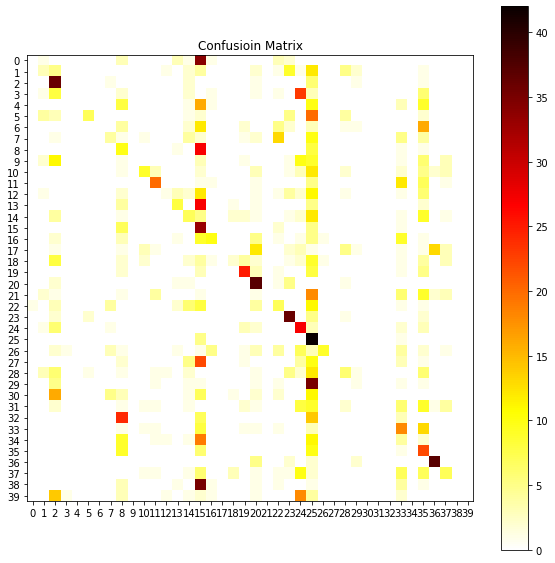

Accuracy of each class:
 tensor([0.0000, 0.0625, 0.7500, 0.0000, 0.0000, 0.1458, 0.0000, 0.0833, 0.2083,
        0.0000, 0.1875, 0.4167, 0.0208, 0.1667, 0.1458, 0.6875, 0.2083, 0.0000,
        0.0417, 0.5208, 0.7708, 0.0000, 0.1458, 0.7500, 0.5625, 0.8750, 0.1875,
        0.0000, 0.1250, 0.0208, 0.0000, 0.0000, 0.0000, 0.3750, 0.0000, 0.4583,
        0.7708, 0.1458, 0.0000, 0.0000])
Recall of each class:
 tensor([0.0000, 0.1667, 0.2609, 0.0000, 0.0000, 0.7000, 0.0000, 0.2222, 0.0909,
        0.0000, 0.5000, 0.5882, 0.2000, 0.3810, 0.1522, 0.1019, 0.4545, 0.0000,
        0.2222, 0.5814, 0.3854, 0.0000, 0.1522, 0.4675, 0.2195, 0.1167, 0.8182,
        0.0000, 0.2143, 0.1111, 0.0000, 0.0000, 0.0000, 0.1765, 0.0000, 0.1333,
        0.6727, 0.2414, 0.0000, 0.0000])
Epoch 2/40: , lr = 0.3
Step [10/60] Train Loss: 2.7540
Step [20/60] Train Loss: 2.9536
Step [30/60] Train Loss: 2.7937
Step [40/60] Train Loss: 2.6365
Step [50/60] Train Loss: 2.4464
Step [60/60] Train Loss: 2.6722
Accuracy on Tes

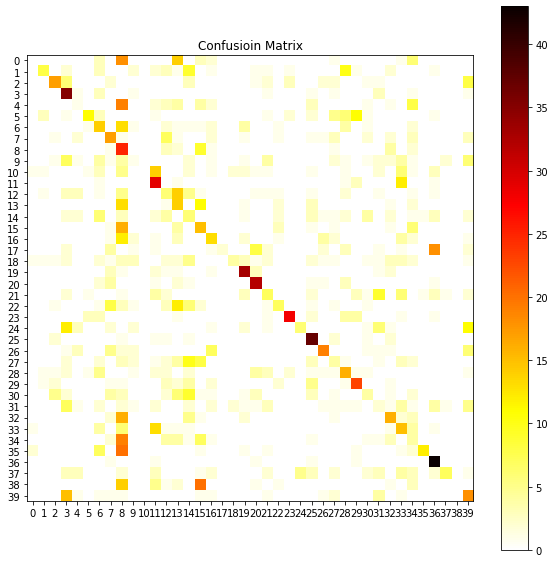

Accuracy of each class:
 tensor([0.0000, 0.1667, 0.3542, 0.7292, 0.0208, 0.2292, 0.2917, 0.3542, 0.5208,
        0.0208, 0.0000, 0.6042, 0.1250, 0.2917, 0.1250, 0.3125, 0.2708, 0.0417,
        0.0833, 0.6875, 0.6667, 0.1458, 0.1458, 0.5833, 0.1250, 0.7708, 0.3958,
        0.0833, 0.3333, 0.4792, 0.0833, 0.0417, 0.3333, 0.3125, 0.0833, 0.2500,
        0.8958, 0.1458, 0.0000, 0.3750])
Recall of each class:
 tensor([0.0000, 0.5000, 0.5484, 0.3302, 0.0476, 0.6111, 0.2000, 0.2787, 0.1078,
        0.0500, 0.0000, 0.3333, 0.1132, 0.1458, 0.0800, 0.1744, 0.2955, 1.0000,
        0.5000, 0.5690, 0.5517, 0.2000, 0.3333, 0.7778, 0.5455, 0.4744, 0.5588,
        0.1143, 0.2857, 0.4694, 0.1600, 0.0513, 0.3333, 0.2206, 0.0645, 0.8571,
        0.5181, 0.6364, 0.0000, 0.2647])
Epoch 3/40: , lr = 0.3


In [ ]:
fit(net, num_epochs, optimizer, schedulr,device, nclasses)  #

In [ ]:
training_dataset[0]